In [277]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy
import astropy.units as u
import astropy.constants as ac
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob
from pathlib import Path


from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import silhouette_score, confusion_matrix, f1_score



import random
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils
import json

import ipywidgets as widgets

import datetime
from tqdm.notebook import tqdm


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [46]:
latent_size = 1024
batch_size = 48
all_gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0, shuffle=False, noise_filter=True)
all_gen_input.take_all = True

25650
19012


In [47]:
weights = tf.constant([0.5,0.5,2])
def modified_mse(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(tf.reduce_mean(squared_difference, axis=(0,1,2)) * weights) # Note the `axis=-1`

autoencoder = keras.models.load_model("autoencoder_VAE_ft_1024_xception.h5", custom_objects={"modified_mse": modified_mse})
encoder = keras.models.load_model("encoder_VAE_ft_1024_xception.h5")
decoder = keras.models.load_model("decoder_VAE_ft_1024_xception.h5")

/home/eugeniolr/Documents/master/TFM/data_generator.py:194: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:195: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:203: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


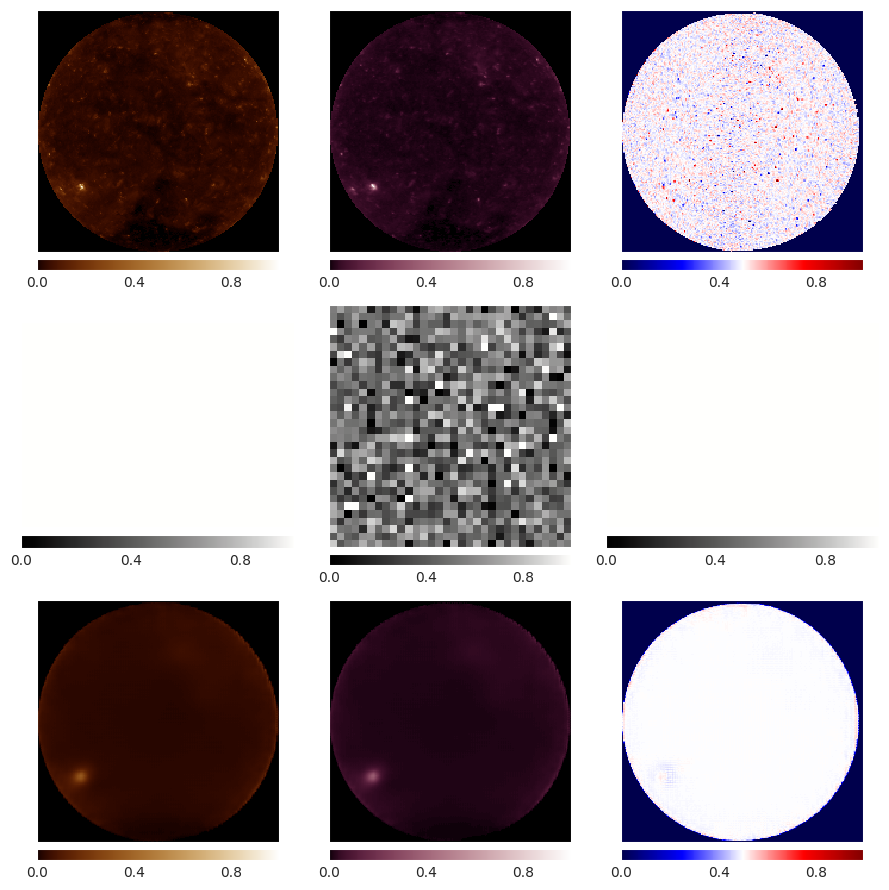

In [48]:
test_img = all_gen_input.sample(1)
#code = encoder(test_img)
mean, var, code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)

In [49]:
path = Path("encoded_images.npy")

if path.is_file():
    codes = np.load("encoded_images.npy")
else:
    latent_size = 1024
    codes = np.empty((len(all_gen_input.file_list), latent_size))
    for idx, val in tqdm(enumerate(all_gen_input), total=len(all_gen_input), desc="Encoding images"):
        codes[batch_size*idx:batch_size*(idx+1)] = encoder.predict(val[0], verbose=False)[2]

    np.save("encoded_images.npy", codes)

In [50]:
codes.shape

(19012, 1024)

In [51]:
solar_wind_class = pd.read_csv("./is_fast_solar_wind.csv", index_col=0)
solar_wind_class = solar_wind_class.sort_values(by="datetime")
solar_wind_class["is_fast_wind"] = solar_wind_class["is_fast_wind"] == 1
solar_wind_class

,datetime,is_fast_wind,CME
14371,2012-10-03 03:30:19,False,False
4008,2012-10-03 04:06:22,False,False
15240,2012-10-03 04:42:56,False,False
5180,2012-10-03 05:19:13,False,False
16610,2012-10-03 05:55:39,False,False
...,...,...,...
12491,2020-07-03 03:43:17,False,False
17829,2020-07-03 04:50:23,False,False
9694,2020-07-03 05:56:43,False,False
165,2020-07-03 07:03:03,False,False


In [52]:
print(f"Nº fast wind days: {np.count_nonzero(solar_wind_class['is_fast_wind']):6d} out ot {len(solar_wind_class)}")
print(f"Nº CME days:       {np.count_nonzero(solar_wind_class['CME']):6d} out ot {len(solar_wind_class)}")

Nº fast wind days:   1825 out ot 19012
Nº CME days:          754 out ot 19012


In [53]:
codes_fw_train, codes_fw_test, target_fw_train, target_fw_test = train_test_split(codes, solar_wind_class["is_fast_wind"].astype(int), test_size=0.2, shuffle=True, stratify=solar_wind_class["is_fast_wind"])
codes_cme_train, codes_cme_test, target_cme_train, target_cme_test = train_test_split(codes, solar_wind_class["CME"].astype(int), test_size=0.2, shuffle=True, stratify=solar_wind_class["CME"])

In [54]:
print("Fast wind Train:")
print(f"\tNº of data points: {target_fw_train.size}")
print(f"\tFor class 0: {np.count_nonzero(target_fw_train == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_fw_train == 1)}")
print()
print("Fast wind Test:")
print(f"\tNº of data points: {target_fw_test.size}")
print(f"\tFor class 0: {np.count_nonzero(target_fw_test == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_fw_test == 1)}")

Fast wind Train:
	Nº of data points: 15209
	For class 0: 13749
	For class 1: 1460

Fast wind Test:
	Nº of data points: 3803
	For class 0: 3438
	For class 1: 365


In [55]:
print("CME Train:")
print(f"\tNº of data points: {target_cme_train.size}")
print(f"\tFor class 0: {np.count_nonzero(target_cme_train == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_cme_train == 1)}")
print()
print("CME Test:")
print(f"\tNº of data points: {target_cme_test.size}")
print(f"\tFor class 0: {np.count_nonzero(target_cme_test == 0)}")
print(f"\tFor class 1: {np.count_nonzero(target_cme_test == 1)}")

fw Train:
	Nº of data points: 15209
	For class 0: 13749
	For class 1: 1460

CME Test:
	Nº of data points: 3803
	For class 0: 3652
	For class 1: 151


In [56]:
conf_mat_norm = "true"

## Gaussian Mixture Model for generation

# Naive Bayes

In [57]:
model_fw = GaussianNB(var_smoothing=5e-4)

model_fw = model_fw.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw.predict(codes_fw_train)
pred_fw_test = model_fw.predict(codes_fw_test)

print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")

Fast solar wind F1 score:
Test: 0.233235
Train: 0.213825


In [58]:
model_cme = GaussianNB(var_smoothing=5e-4)

model_cme = model_cme.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme.predict(codes_cme_train)
pred_cme_test = model_cme.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

CME F1 score:
Test: 0.154733
Train: 0.162308


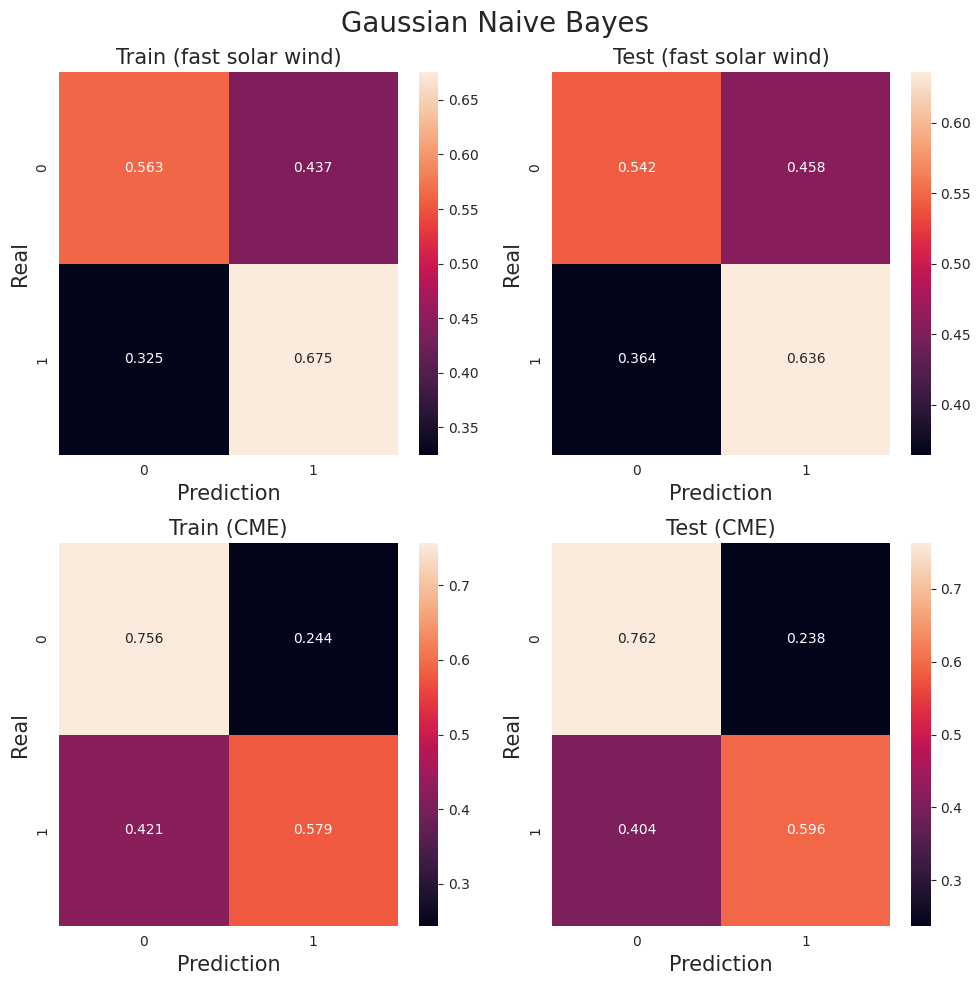

In [59]:
train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Gaussian Naive Bayes", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

## Since Knn works best, use it to validate generated images

Fast solar wind F1 score:
Test: 1.000000
Train: 0.887381
CME F1 score:
Test: 1.000000
Train: 0.930233


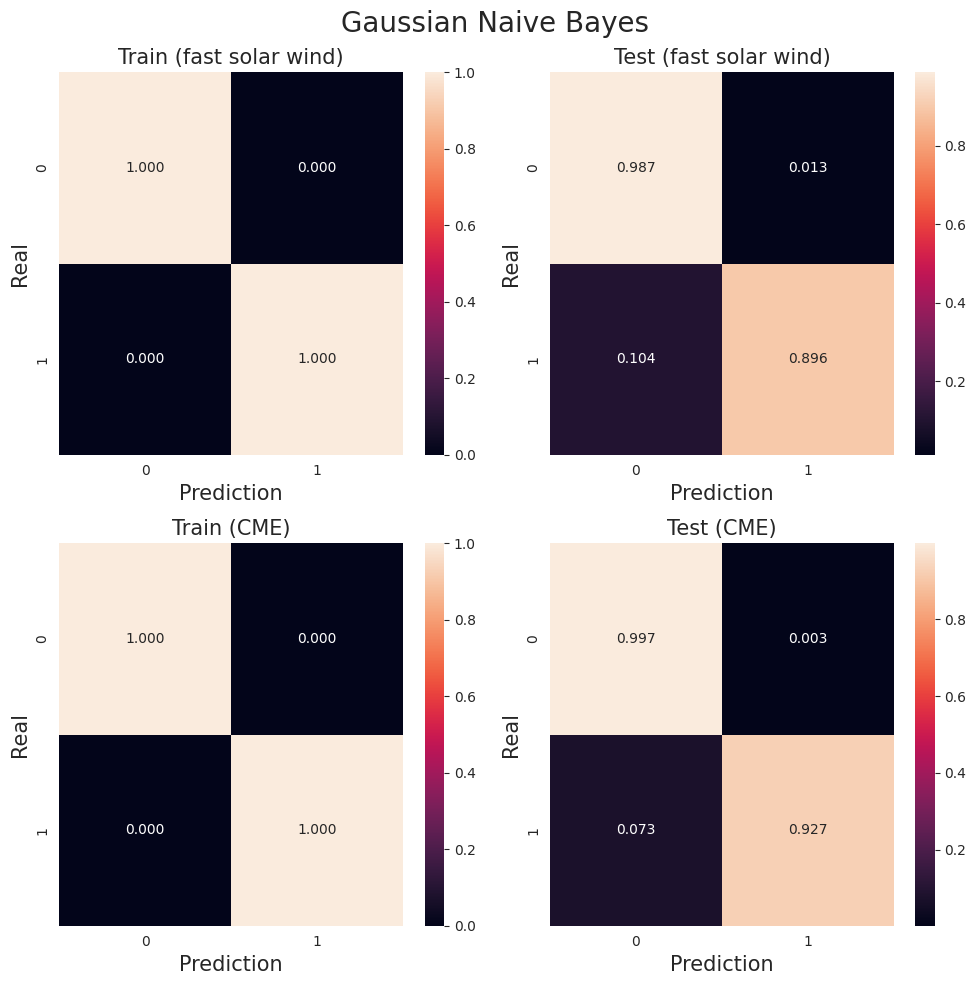

In [60]:
model_fw_knn = KNeighborsClassifier(n_neighbors=1)

model_fw_knn = model_fw_knn.fit(codes_fw_train, target_fw_train)

pred_fw_train = model_fw_knn.predict(codes_fw_train)
pred_fw_test = model_fw_knn.predict(codes_fw_test)


print("Fast solar wind F1 score:")
print(f"Test: {f1_score(pred_fw_train, target_fw_train):4f}")
print(f"Train: {f1_score(pred_fw_test, target_fw_test):4f}")


model_cme_knn = KNeighborsClassifier(n_neighbors=1)

model_cme_knn = model_cme_knn.fit(codes_cme_train, target_cme_train)

pred_cme_train = model_cme_knn.predict(codes_cme_train)
pred_cme_test = model_cme_knn.predict(codes_cme_test)

print("CME F1 score:")
print(f"Test: {f1_score(pred_cme_train, target_cme_train):4f}")
print(f"Train: {f1_score(pred_cme_test, target_cme_test):4f}")

train_fw_confmat = confusion_matrix(target_fw_train, pred_fw_train, normalize=conf_mat_norm)
test_fw_confmat = confusion_matrix(target_fw_test, pred_fw_test, normalize=conf_mat_norm)
train_cme_confmat = confusion_matrix(target_cme_train, pred_cme_train, normalize=conf_mat_norm)
test_cme_confmat = confusion_matrix(target_cme_test, pred_cme_test, normalize=conf_mat_norm)

fig, ax = plt.subplots(2,2,figsize=(10,10))

fig.suptitle("Gaussian Naive Bayes", fontsize=20)

heatmap_ax = sns.heatmap(train_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (fast solar wind)")

heatmap_ax = sns.heatmap(test_fw_confmat, annot=True, fmt="0.3f", ax=ax[0,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (fast solar wind)")

heatmap_ax = sns.heatmap(train_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,0])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Train (CME)")

heatmap_ax = sns.heatmap(test_cme_confmat, annot=True, fmt="0.3f", ax=ax[1,1])
heatmap_ax.set(xlabel="Prediction", ylabel="Real", title="Test (CME)")

plt.tight_layout()
plt.show()

In [61]:
def sample_nb(nb_model, class_n, sigma_scaler=1, k=1):
    mean = nb_model.theta_[class_n, :]
    sigma = np.sqrt(nb_model.var_[class_n, :])*sigma_scaler

    distribution = scipy.stats.norm(mean, sigma)
    return np.array([distribution.rvs() for i in range(k)])

# Generate with/without fast solar wind

In [70]:
generated_samples = sample_nb(model_fw, 0, sigma_scaler=1, k=10000)
pred = model_fw_knn.predict(generated_samples)
np.count_nonzero(pred==0)

9192

In [71]:
generated_samples = sample_nb(model_fw, 1, sigma_scaler=1, k=10000)
pred = model_fw_knn.predict(generated_samples)
np.count_nonzero(pred==1)

1267

[0] 1


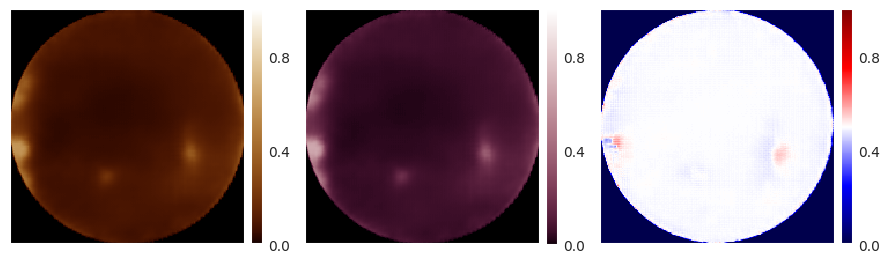

In [144]:
loops = 0
knn_pred = -1
while knn_pred != 0:
    sampled_code = sample_nb(model_fw, 0, k=1)
    sampled_image = decoder(sampled_code)
    knn_pred = model_fw_knn.predict(sampled_code)
    loops += 1
print(knn_pred, loops)

isns.rgbplot(sampled_image[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

[1] 2


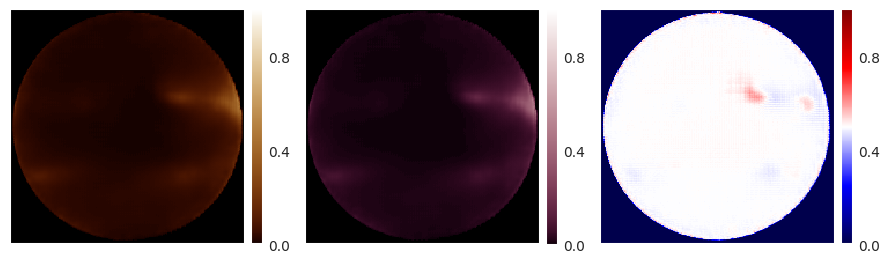

In [74]:
loops = 0
knn_pred = -1
while knn_pred != 1:
    sampled_code = sample_nb(model_fw, 1, k=1)
    sampled_image = decoder(sampled_code)
    knn_pred = model_fw_knn.predict(sampled_code)
    loops += 1
print(knn_pred, loops)

isns.rgbplot(sampled_image[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

# Generate with/without CME 

In [75]:
generated_samples = sample_nb(model_cme, 0, sigma_scaler=1, k=10000)
pred = model_cme_knn.predict(generated_samples)
np.count_nonzero(pred==0)

9956

In [76]:
generated_samples = sample_nb(model_cme, 1, sigma_scaler=1, k=10000)
pred = model_cme_knn.predict(generated_samples)
np.count_nonzero(pred==1)

74

[0] 1


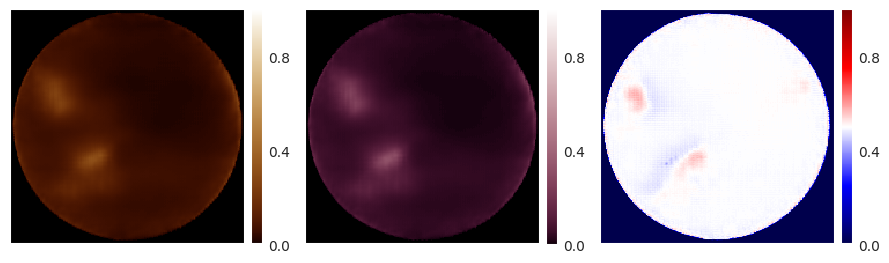

In [77]:
loops = 0
knn_pred = -1
while knn_pred != 0:
    sampled_code = sample_nb(model_cme, 0, k=1)
    sampled_image = decoder(sampled_code)
    knn_pred = model_cme_knn.predict(sampled_code)
    loops += 1
print(knn_pred, loops)

isns.rgbplot(sampled_image[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

[1] 104


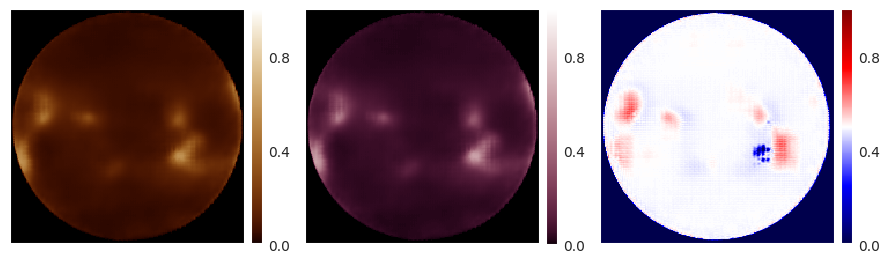

In [80]:
loops = 0
knn_pred = -1
while knn_pred != 1:
    sampled_code = sample_nb(model_cme, 1, k=1)
    sampled_image = decoder(sampled_code)
    knn_pred = model_cme_knn.predict(sampled_code)
    loops += 1
print(knn_pred, loops)

isns.rgbplot(sampled_image[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

# Generate sequence with interpolation

## CME to non-CME

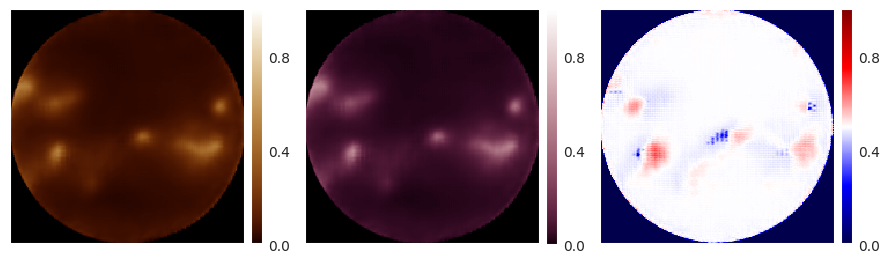

In [176]:
# Randomly choose a coded image that is related to a CME

chosen_cme_idx = np.random.choice(np.where(solar_wind_class["CME"].astype(int) == 1)[0])

example_CME_code = codes[chosen_cme_idx:chosen_cme_idx+1]

isns.rgbplot(decoder(example_CME_code)[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

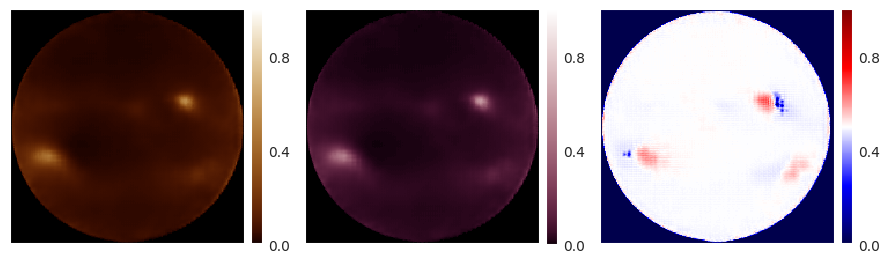

In [183]:
# Search for the closest coded image that isn't related to a CME

dist = []
for i in np.where(solar_wind_class["CME"].astype(int) == 0)[0]:
    new_code = codes[i]

    d = np.sqrt(np.sum((new_code - codes[chosen_cme_idx])**2))

    dist.append(d)

dist = np.asarray(dist)
closest_noncme_idx = np.argmin(dist)

# Display decoded image

example_nonCME_code = codes[closest_noncme_idx:closest_noncme_idx+1]

isns.rgbplot(decoder(example_nonCME_code)[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

(6, 1024)
(4, 204, 204, 3)


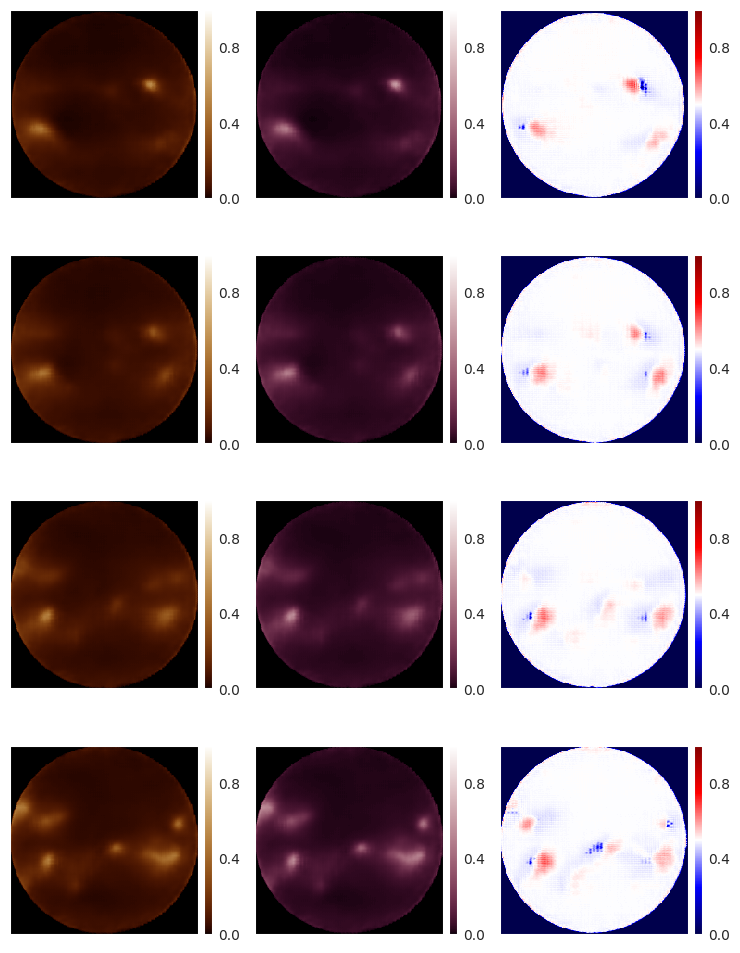

In [207]:
# Visualize a small number of steps

n_steps = 4

interpolated_CME_codes = np.linspace(example_nonCME_code[0], example_CME_code[0], n_steps)

print(interpolated_CME.shape)

interpolated_CME_images = np.asarray(decoder(interpolated_CME_codes))
print(interpolated_CME_images.shape)

plot_imgs_list = []
for img in interpolated_CME_images:
    plot_imgs_list += [img[:,:,0], img[:,:,1], img[:,:,2]]

isns.ImageGrid(plot_imgs_list, col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*n_steps,vmin=0, vmax=1, height=2.5)


In [291]:
def gif_from_seq(img_seq, file_name="seq.gif"):
    imgs = [Image.fromarray(img) for img in img_seq]
    imgs[0].save(file_name, save_all=True, append_images=imgs[1:], loop=0)

gif_from_seq(np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8))

<Axes: >

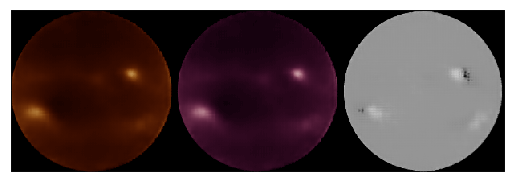

In [309]:
def create_display_img(code):
    new_img = decoder(code)[0]

    new_img_193_col = mpl.colormaps['sdoaia193'](new_img[:,:,0])
    new_img_211_col = mpl.colormaps['sdoaia211'](new_img[:,:,1])
    new_img_hmi_col = mpl.colormaps['Greys_r'](new_img[:,:,2])

    full = np.concatenate([new_img_193_col, np.ones([204,3,4])*np.array([0,0,0,1]), new_img_211_col, np.ones([204,3,4])*np.array([0,0,0,1]), new_img_hmi_col], axis=1)
    return full[:,:,:3]

isns.imgplot(create_display_img(example_nonCME_code))


In [310]:
# Generate a gif with a larger amount of frames

n_steps = 100

interpolated_CME_codes = np.linspace(example_nonCME_code[0], example_CME_code[0], n_steps)


frames = []
for img_code in interpolated_CME_codes:
    display_frame = create_display_img(np.asarray([img_code]))

    display_frame = (display_frame*256).astype(np.uint8)
    frames.append(display_frame)

gif_from_seq(frames, "noCME_to_CME.gif")

# Fast wind to Non fast wind

In [ ]:
# Randomly choose a coded image that is related to fast wind

chosen_cme_idx = np.random.choice(np.where(solar_wind_class["is_fast_wind"].astype(int) == 1)[0])

example_CME_code = codes[chosen_cme_idx:chosen_cme_idx+1]

isns.rgbplot(decoder(example_CME_code)[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

In [ ]:
# Search for the closest coded image that isn't related to fast wind

dist = []
for i in np.where(solar_wind_class["is_fast_wind"].astype(int) == 0)[0]:
    new_code = codes[i]

    d = np.sqrt(np.sum((new_code - codes[chosen_cme_idx])**2))

    dist.append(d)

dist = np.asarray(dist)
closest_noncme_idx = np.argmin(dist)

# Display decoded image

example_nonCME_code = codes[closest_noncme_idx:closest_noncme_idx+1]

isns.rgbplot(decoder(example_nonCME_code)[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)